In [2]:
import os
import cooler
import cooltools.snipping
import bioframe
import pandas as pd
from NGS import HiCTools as HT
from collections import defaultdict
import re
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.colors as cl
import matplotlib
import warnings

In [3]:
# ignore warnings (log10(0))
warnings.simplefilter("ignore", RuntimeWarning)

# Define plotting parameters

In [4]:
matplotlib.rcParams.update({"font.size": 12})
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define functions

In [5]:
def recDict():
    return defaultdict(recDict)

def getPairingScoreObsExp(clr: cooler.Cooler, expected: pd.DataFrame ,windowsize: int = 4 * 10**4,
                    func: Callable = np.mean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupObsExp(clr, expected, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    # replace inf with nan
    pileFrame = pileFrame.replace([np.inf, -np.inf], np.nan)
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

def getDiagIndices(arr):
    assert arr.shape[0] == arr.shape[1], "Please supply a square array!"
    shape = arr.shape[0]
    return [i + index for index, i in enumerate(range(0, shape**2 - shape + 1, shape))]

def getPairingScore(clr: cooler.Cooler, windowsize: int = 4 * 10**4,
                    func: Callable = np.mean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True, blankDiag: bool = False) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupICCF(clr, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    if blankDiag:
        dummyarray = np.arange(pile[:, :, 0].shape[0]**2).reshape(pile[:, :, 0].shape[0], pile[:, :, 0].shape[0])
        indices = getDiagIndices(dummyarray)
        pileFrame.iloc[:, indices] = np.nan
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

def setAxis(ax, ticks_pixels, ticks_kbp):
    if not isinstance(ax, np.ndarray):
        ax.set_xticks(ticks_pixels)
        ax.set_xticklabels(ticks_kbp)
        ax.set_yticks(ticks_pixels)
        ax.set_yticklabels(ticks_kbp)
        ax.set_xlabel('relative position, kbp')
        ax.set_ylabel('relative position, kbp')
        return
    if len(ax.shape) == 1:
        for i in range(len(ax)):
            ax[i].set_xticks(ticks_pixels)
            ax[i].set_xticklabels(ticks_kbp)
            ax[i].set_yticks(ticks_pixels)
            ax[i].set_yticklabels(ticks_kbp)
            ax[i].set_xlabel('relative position, kbp')
            ax[i].set_ylabel('relative position, kbp')
        return
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].set_xticks(ticks_pixels)
            ax[i, j].set_xticklabels(ticks_kbp)
            ax[i, j].set_yticks(ticks_pixels)
            ax[i, j].set_yticklabels(ticks_kbp)
            ax[i, j].set_xlabel('relative position, kbp')
            ax[i, j].set_ylabel('relative position, kbp')

# from https://stackoverflow.com/questions/10925671/numpy-k-th-diagonal-indices
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

# http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(cl.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		cl.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

# Set wd

In [6]:
os.chdir("/groups/gerlich/experiments/Experiments_004800/004869/")

# Load in data

In [7]:
chromsizes = bioframe.fetch_chromsizes('hg19')
arms = HT.getArmsHg19()

In [8]:
HICPATHWT = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/"

BINSIZE = 10000
BARCODE = "G2.fc_1_2_3_4.wOldG2"
clrsWT = {interType:
        cooler.Cooler(
            os.path.join(HICPATHWT, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

In [9]:
HICPATHNipbl = "./Sequencing_data/Pooled/cooler/"

BINSIZE = 10000
BARCODE = "G2.Nipbl-AID.wAuxin"
clrsNipbl = {interType:
        cooler.Cooler(
            os.path.join(HICPATHNipbl, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

In [17]:
HICPATHSororin = "./Sequencing_data/Pooled/cooler/"

BINSIZE = 10000
BARCODE = "G2.Sororin-AID.wAuxin"
clrsSororin = {interType:
        cooler.Cooler(
            os.path.join(HICPATHSororin, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

# Load TADs

In [10]:
tadFrame = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)[[0, 1, 2]]
tadFrame.columns = ["chrom", "start", "end"]

# Calculate boundaries

In [11]:
# boundaries are gonna be stard and end together
tadStart = tadFrame[["chrom", "start"]]
tadStart.columns = ["chrom", "mid"]
tadEnd = tadFrame[["chrom", "end"]]
tadEnd.columns = ["chrom", "mid"]
# here duplicates are removed
tadFinal = pd.concat((tadStart, tadEnd)).drop_duplicates()

# Get amount of contacts at boundaries

In [20]:
wtPairICCF = {}
for rType in ["cis", "trans"]:
    wtPairICCF[rType] = getPairingScore(clrsWT[rType], regions=tadFinal, norm=False, windowsize=20 * 10**4)
    # add Pseudocount
    wtPairICCF[rType].loc[:, "PairingScorePseudo"] = wtPairICCF[rType]["PairingScore"] + 0.0001
    wtPairICCF[rType].loc[:, "log2Pair"] = np.log2(wtPairICCF[rType]["PairingScorePseudo"])
    wtPairICCF[rType] = wtPairICCF[rType].replace([np.inf, -np.inf], np.nan).dropna()

In [21]:
nipblPairICCF = {}
for rType in ["cis", "trans"]:
    nipblPairICCF[rType] = getPairingScore(clrsNipbl[rType], regions=tadFinal, norm=False, windowsize=20 * 10**4)
    # add Pseudocount
    nipblPairICCF[rType].loc[:, "PairingScorePseudo"] = nipblPairICCF[rType]["PairingScore"] + 0.0001
    nipblPairICCF[rType].loc[:, "log2Pair"] = np.log2(nipblPairICCF[rType]["PairingScorePseudo"])
    nipblPairICCF[rType] = nipblPairICCF[rType].replace([np.inf, -np.inf], np.nan).dropna()

In [22]:
sororinPairICCF = {}
for rType in ["cis", "trans"]:
    sororinPairICCF[rType] = getPairingScore(clrsSororin[rType], regions=tadFinal, norm=False, windowsize=20 * 10**4)
    # add Pseudocount
    sororinPairICCF[rType].loc[:, "PairingScorePseudo"] = sororinPairICCF[rType]["PairingScore"] + 0.0001
    sororinPairICCF[rType].loc[:, "log2Pair"] = np.log2(sororinPairICCF[rType]["PairingScorePseudo"])
    sororinPairICCF[rType] = sororinPairICCF[rType].replace([np.inf, -np.inf], np.nan).dropna()

# Plot result with pseudocount

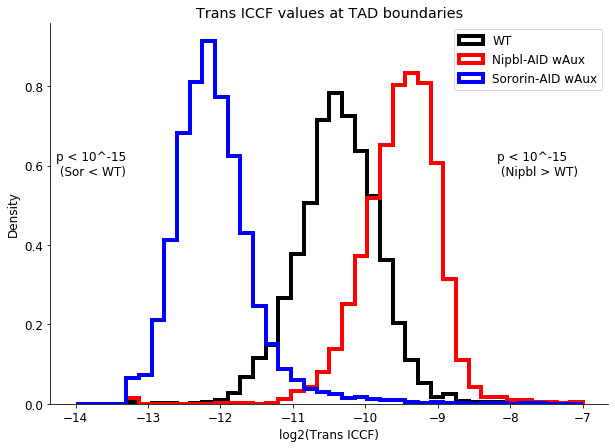

In [36]:
# perform ttest

sSor, pSor = mannwhitneyu(sororinPairICCF["trans"]["PairingScore"], wtPairICCF["trans"]["PairingScore"], alternative="two-sided")
try:
    orderOfMagSor = int(np.log10(pSor))
except OverflowError:
    # in case p-value is closer to 0 than the precision limit of np.float64
    orderOfMagSor = -15

sNipbl, pNipbl = mannwhitneyu(nipblPairICCF["trans"]["PairingScore"], wtPairICCF["trans"]["PairingScore"], alternative="two-sided")
try:
    orderOfMagNipbl = int(np.log10(pNipbl))
except OverflowError:
    # in case p-value is closer to 0 than the precision limit of np.float64
    orderOfMagSor = -15


f, ax = plt.subplots()
ax.hist(wtPairICCF["trans"]["log2Pair"], density=True, bins=40, range=(-14, -7), histtype="step", color="black", lw=4, label="WT")
ax.hist(nipblPairICCF["trans"]["log2Pair"], density=True, bins=40, range=(-14, -7), histtype="step", color="red", lw=4, label="Nipbl-AID wAux")
ax.hist(sororinPairICCF["trans"]["log2Pair"], density=True, bins=40, range=(-14, -7), histtype="step", color="blue", lw=4, label="Sororin-AID wAux")
ax.set(xlabel="log2(Trans ICCF)", ylabel="Density", title="Trans ICCF values at TAD boundaries")
ax.text(0.01, 0.6, f"p < 10^{orderOfMag}\n (Sor < WT)", transform=ax.transAxes)
ax.text(0.8, 0.6, f"p < 10^{orderOfMag}\n (Nipbl > WT)", transform=ax.transAxes)
ax.legend()
sbn.despine()
f.set_size_inches(10, 7)
plt.show()

## save result

In [37]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results"
f.savefig(os.path.join(resultsdir, "ICCF_comp_Sor_Nipbl_WT.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "ICCF_comp_Sor_Nipbl_WT.pdf"), bbox_inches="tight")